## Look at MERSCOPE panel classification accuracy
Quick notebook to compare classification accuracy, basically a subset of Cluster Benchmarking

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import pickle
import json

In [4]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/clData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# Acquire genes
def getUniqueGenes(geneDict, perClass = 1):
    """ Function to find X number of genes per class for a given gene dictionary, and assemble them
    into a list of unique genes. """
    import numpy as np
    
    keyNames = list(geneDict.keys())
    if perClass > len(geneDict[keyNames[0]]):
        print("Requested genes per class greater than number contained within first dict element - using that instead.")
        perClass = len(geneDict[keyNames[0]])
    
    geneList = []
    for name in keyNames:
        geneList.append(geneDict[name][0:perClass])
        
    geneList = np.unique(geneList)
    return geneList

In [183]:
def evalPanel(geneData,genePanel,cluster):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Get confusion matrix
    confMatrix = confusion_matrix(cluster,assignedCluster)
    return accuracy, confMatrix

In [7]:
# Create a super list dictionary of top marker genes for each subclass, which can be later indexed for specific gene panels
markerGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:500,:]
    genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
    markerGenes[indx] = genesFiltered["names"][0:32].tolist()
    
# Assemble a dictionary w/ varying length gene panels
wlPanel = {}
panelIDs = [1, 2, 3, 4, 8, 16, 32]
for i in panelIDs:
    geneList = list(getUniqueGenes(markerGenes,i))
    wlPanel[str(len(geneList))] = geneList

In [10]:
with open("../Data/Gene Panels/scGeneFit_cluster_genes.json", "r") as f:
    gfPanel = json.load(f)
    
with open("../Data/Gene Panels/PROPOSE_cluster_genes.json", "r") as f:
    prPanel = json.load(f)
    
with open("../Data/Gene Panels/activeSVM_cluster_genes.json", "r") as f:
    svPanel = json.load(f)
    
with open("../Data/Gene Panels/MERSCOPE_cluster_genes.json", "r") as f:
    fbPanel = json.load(f)

In [185]:
# Systematically evaluate gene panels
[wlAccuracy,wlMatrix] = evalPanel(gluData,wlPanel['448'],gluData.obs["cluster_label"])
[gfAccuracy,gfMatrix] = evalPanel(gluData,gfPanel['500'],gluData.obs["cluster_label"])
[prAccuracy,prMatrix] = evalPanel(gluData,prPanel['500'],gluData.obs["cluster_label"])
[svAccuracy,svMatrix] = evalPanel(gluData,svPanel['500'],gluData.obs["cluster_label"])
[fbAccuracy,fbMatrix] = evalPanel(gluData,fbPanel['500'],gluData.obs["cluster_label"])

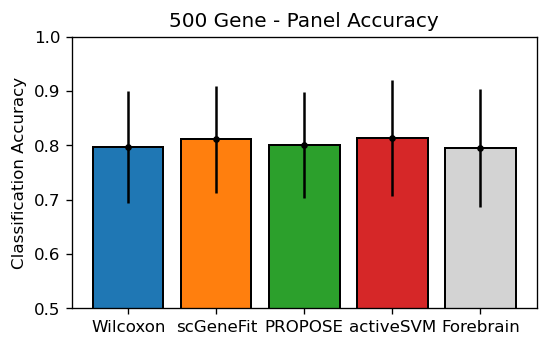

In [182]:
# Plot error bar comparison of each 500 gene panel
# Compute standard deviation
wlError = np.std(np.diag(wlMatrix))
gfError = np.std(np.diag(gfMatrix))
prError = np.std(np.diag(prMatrix))
svError = np.std(np.diag(svMatrix))
fbError = np.std(np.diag(fbMatrix))

# Make plots
plt.figure(figsize=(5, 3), dpi=120)
# ax.bar(["Wilcoxon","PROPOSE","scGeneFit","activeSVM","MERSCOPE"],[wilAccuracy[4],prAccuracy,gfAccuracy,svAccuracy,mrAccuracy],
#       edgecolor = 'black',linewidth = 2)
plt.bar('Wilcoxon',wlAccuracy, edgecolor = 'black', linewidth = 1.2)
plt.bar('scGeneFit',gfAccuracy, edgecolor = 'black', linewidth = 1.2)
plt.bar('PROPOSE',prAccuracy, edgecolor = 'black', linewidth = 1.2)
plt.bar('activeSVM',svAccuracy, edgecolor = 'black', linewidth = 1.2)
plt.bar('Forebrain',fbAccuracy,  facecolor = 'lightgray', edgecolor = 'black', linewidth = 1.2)
plt.errorbar(['Wilcoxon','PROPOSE','scGeneFit','activeSVM','Forebrain'],
             [wlAccuracy, prAccuracy, gfAccuracy, svAccuracy, fbAccuracy],
             yerr = [wlError, prError,gfError,svError,fbError], fmt = '.k')
plt.ylim(0.5, 1)
plt.ylabel("Classification Accuracy")
plt.title("500 Gene - Panel Accuracy")

plt.savefig('../Figures/forebrain panel comparison.svg')